# ICESat-02 ATL03 Subset and Visualize

About ATL03 Data: 
(ATL03) contains height above the WGS 84 ellipsoid (ITRF2014 reference frame), latitude, longitude, and time for all photons downlinked by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory. The ATL03 product was designed to be a single source for all photon data and ancillary information needed by higher-level ATLAS/ICESat-2 products. As such, it also includes spacecraft and instrument parameters and ancillary data not explicitly required for ATL03. (source: https://nsidc.org/data/atl03/versions/5)

Required packages:

You will need to install the following required packages if not already present in your working environment: 
maap-py, 
pandas, 
geopandas, 
folium, 
shapely, 
h5glance, 
h5py

### Import relevant python modules

In [1]:
# Import the MAAP package
from maap.maap import MAAP

# Invoke the MAAP constructor using the maap_host argument
maap = MAAP(maap_host='api.ops.maap-project.org')

# Import pandas dataframe
import pandas as pd

# Import libraries needed for visualizing data spatial extent
import geopandas as gpd
import folium
from shapely.geometry import Polygon,Point

# Import H5glance to interactively explore H5 file in notebook
from h5glance import H5Glance

# Import H5py to read h5 file
import h5py

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Decide on a subset of ATL03 data to load using spatial extent and date range and visualize extent using folium

In [2]:
# Create a variable for short name of ATL03 data
short_name = 'ATL03'

# Create spatial extent for which we will search 
# ATL03 granules on NASA CMR. We have chosen a very narrow 
# area over Yosemite national park. This is okay, 
# as we need just a few granules for demo purposes.

# Create Latitude, Longitude list.
lat_coords = [37.700057,37.700057,37.758166,37.758166,37.700057]
lon_coords = [-119.680359,-119.680359,-119.538910,-119.538910,-119.680359]

# Create bounding box
spatial_extent = [lon_coords[0],lat_coords[0],lon_coords[2],lat_coords[2]]

# Reformat bounding box to work with NASA CMR API
spatial_extent = ','.join(str(coords) for coords in spatial_extent)

#Provide date range. It is just 1 day. 
date_range = ['2021-02-02','2022-02-03']

# For folium purpose, provide the map center
map_center = [37.729139,-119.609670]

# Convert to AOI for visualizaton with folium
polygon_geom = Polygon(zip(lon_coords, lat_coords))

# Provide relevant Coordinate Reference System
crs = 'epsg:4326'

# Convert to Geodataframe and back to list in that specific reference system
AOI = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
AOI_bbox = AOI.bounds.iloc[0].to_list()

In [3]:
# Visualize the spatial extent using folium.
m = folium.Map(map_center, zoom_start=12, tiles='OpenStreetMap')
folium.GeoJson(AOI).add_to(m)
folium.LatLngPopup().add_to(m)
m

### Search for available granules in the NASA CMR for the given spatial extent and date range and print the number of granules available.

In [4]:
# Provide the name of cmr host to use with maap py
nasa_cmr_host = "cmr.earthdata.nasa.gov"
# Search granule using maap-py using subset criteria identified earlier.
data = maap.searchGranule(cmr_host=nasa_cmr_host,short_name = short_name, bounding_box = spatial_extent,temporal= date_range,limit=1000)
# Check to see if the granule search was successfull in finding data within spatial and temporal extent
print(len(data))

68


In [5]:
#Use maap-py's getDatafunction to extract one of the HDF files from NSIDC servers.
# Print the name of file extracted. The file will be downloaded and stored in your current directory

ice_data = data[0].getData()
print(ice_data)

./ATL03_20210202191800_06231006_005_01.h5


### Read the H5 file to understand the data structure. 

##### There are two ways to do this. We can just list keys and then go forward exploring each key one by one.

In [6]:
# Open the H5 file and list the keys
ice_file = h5py.File(ice_data,'r')
list(ice_file.keys())

['METADATA',
 'ancillary_data',
 'atlas_impulse_response',
 'ds_surf_type',
 'ds_xyz',
 'gt1l',
 'gt1r',
 'gt2l',
 'gt2r',
 'gt3l',
 'gt3r',
 'orbit_info',
 'quality_assessment']

##### Or use the h5glance package to interactively list various keys, sub-keys and variables.
H5Glance lists all the keys and sub-keys and allows for the copying of path variables on the fly, all from within the Jupyter Notebook. 
Note: In the web version of this notebook which is shown here, not all sub-fields will be listed. But they can be accessed when using a Jupyter Notebook running on ADE or local machines.

In [7]:
H5Glance(ice_file)

./ATL03_20210202191800_06231006_005_01.h5/ (47 attributes)
├METADATA	(9 children) (3 attributes)
├ancillary_data	(34 children) (2 attributes)
├atlas_impulse_response	(2 children) (1 attributes)
├ds_surf_type	[int32: 5] (12 attributes)
├ds_xyz	[int32: 3] (12 attributes)
├gt1l	(5 children) (7 attributes)
├gt1r	(5 children) (7 attributes)
├gt2l	(5 children) (7 attributes)
├gt2r	(5 children) (7 attributes)
├gt3l	(5 children) (7 attributes)
├gt3r	(5 children) (7 attributes)
├orbit_info	(7 children) (2 attributes)
└quality_assessment	(9 children) (1 attributes)

### Subset the data by required columns. In this case we need Latitude, Longitude, Photon Height and Along Track Distance.

We are using the copied path from the data tree generated by H5Glance above.
Use h5py to read file and variables from the copied path.

In [8]:
with h5py.File(ice_data,'r') as f:
    gt1l_lat = f['/gt1l/heights/lat_ph'][:]
    gt1l_lon = f['/gt1l/heights/lon_ph'][:]
    gt1l_height = f['/gt1l/heights/h_ph'][:]
    gt1l_dist_ph = f['/gt1l/heights/dist_ph_along'][:]

### Show the subset data in a dataframe. 
1. By using Pandas module.

In [9]:
# Write latitude, longitude, photon height and along track distance for gt1l to a dataframe
gt1l_df = pd.DataFrame({'Latitude': gt1l_lat, 'Longitude': gt1l_lon, 'Photon_Height': gt1l_height,'Along_track_distance':gt1l_dist_ph})
gt1l_df

,Latitude,Longitude,Photon_Height,Along_track_distance
0,59.482065,-115.906874,611.887878,16.894447
1,59.482065,-115.906877,580.084106,16.980614
2,59.482064,-115.906882,527.962097,17.122099
3,59.482063,-115.906885,491.036133,17.222527
4,59.482059,-115.906875,616.919922,17.593958
...,...,...,...,...
36561868,33.011390,-119.752303,69.065865,4.154013
36561869,33.011382,-119.752316,-16.501354,5.156162
36561870,33.011380,-119.752329,-108.562981,5.470425
36561871,33.011376,-119.752317,-17.947205,5.871534


2. By using Geopandas module. 

Create geopandas dataframe with a column for point locations in the geometry column, and other relevant variables.

In [10]:
geometry = gpd.points_from_xy(gt1l_lon, gt1l_lat)
data = {'Latitude': gt1l_lat, 'Longitude': gt1l_lon, 'Photon_Height': gt1l_height,'Along_track_distance':gt1l_dist_ph}
gdf = gpd.GeoDataFrame(data,geometry=geometry, crs='EPSG:4326')

# View the resulting geopandas dataframe
print(gdf.head())

    Latitude   Longitude  Photon_Height  Along_track_distance  \
0  59.482065 -115.906874     611.887878             16.894447   
1  59.482065 -115.906877     580.084106             16.980614   
2  59.482064 -115.906882     527.962097             17.122099   
3  59.482063 -115.906885     491.036133             17.222527   
4  59.482059 -115.906875     616.919922             17.593958   

                      geometry  
0  POINT (-115.90687 59.48207)  
1  POINT (-115.90688 59.48206)  
2  POINT (-115.90688 59.48206)  
3  POINT (-115.90689 59.48206)  
4  POINT (-115.90687 59.48206)  


### Visualize photon heights with respect to along track distance for this H5 file (using inputs from geodataframe)

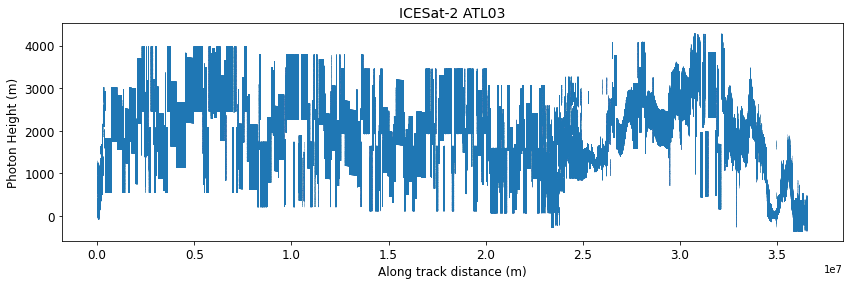

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 4))
gdf.Photon_Height.plot(ax=ax, ls='', marker='.', ms=0.01)
ax.set_xlabel('Along track distance (m)', fontsize=12);
ax.set_ylabel('Photon Height (m)', fontsize=12)
ax.set_title('ICESat-2 ATL03', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)